<a href="https://colab.research.google.com/github/sotha-sil-zen/MCM/blob/main/first_mc_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simple Monte Carlo example

## Getting started

First get yourself setup with Python. You can use [Google Colab](https://colab.google/) through your own Google account, using your CMU Andrew account, or you can install Python locally and run it on your computer.

### Installing Python and Jupyter.

I prefer installing it locally. **It runs about 10--50 times faster locally, even on my 5 year old computer**.
You will need to have the following installed on your computer to run it locally:

1. [Python](https://wiki.python.org/moin/BeginnersGuide/Download). (If you haven't used Python before, do a quick read through of the [Beginners Guide](https://wiki.python.org/moin/BeginnersGuide).)
2. [Numpy](https://numpy.org/install/) and [SciPy](https://scipy.org/install/) (two numerical libraries), and [matplotlib](https://matplotlib.org/stable/users/installing/index.html) for plotting. (Both `numpy` and `scipy` recommend installing through [Anaconda](https://www.anaconda.com/download/); your milage may vary.)
3. [tqdm](https://pypi.org/project/tqdm/#installation). (Technically this is not needed; but it's useful to show progress when you are iterating through a long loop -- something we will do often.) You may also need [ipywidgets](https://github.com/ipython/ipywidgets)
4. [Jupyter](https://jupyter.org/install) in order to run your notebook.

You may already have each of these installed on your system, and your OS may have a simple way to install these directly.
Once you have everything installed, [launch Jupyter and load this notebok](https://docs.jupyter.org/en/latest/running.html). In the menu, do *Run → Restart Kernel and Run All Cells*.

### Using Colab

If you can't install it locally, then try using Colab. **This is much much slower, even if you have an old computer. Do this only if you can't get it installed locally.**
Open <https://colab.research.google.com/>, and sign in. Then import this notebook and open it. From *Runtime* on the top right, click *Connect to a hosted runtime*. After it connects the *Runtime* submenu should have a *Run all* option. Click that.



### Checking it works

Whichever method you use, you should run this notebook yourself and make sure the output looks similar to the HTML version posted on the class website.
The notebook should run without any error messages.
Don't worry about understanding what it does it, we will step through it slowly in class.

In [1]:
%matplotlib inline
import numpy as np, matplotlib as mpl, scipy as sp
from matplotlib import pylab, mlab, pyplot as plt
from tqdm.notebook import tqdm, trange

from numpy import sqrt, pi, exp, log, floor, ceil, sin, cos
from numpy.linalg import norm

rng = np.random.default_rng()

## Computing π

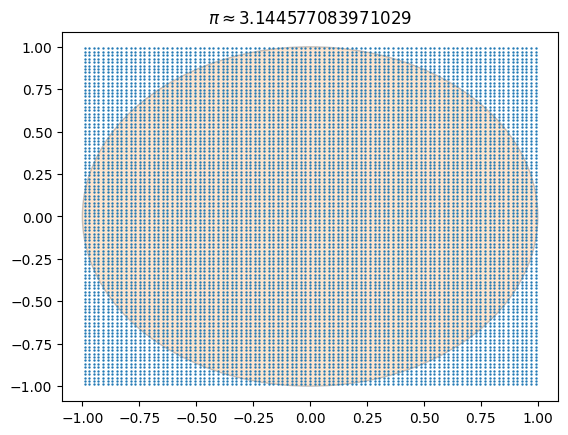

In [2]:
# Compute π by finding the area of the unit circle by quadrature.
N = 10000

# Divide [0, 1]^2 into N squares, and find their centers.
V = np.linspace( -1, 1, num=int(sqrt(N)) )
dx = V[1] - V[0]
V = dx/2 + V[:-1]
(xx, yy) = np.meshgrid( V, V)

plt.gca().add_artist( plt.Circle( (0, 0), 1, color='C1', alpha=.2, ec='k' ) )
plt.scatter( xx, yy, s=.5 )

n_inside = np.sum( sqrt( xx**2 + yy**2 ) < 1 )
_ = plt.title( f'$π \\approx {n_inside * dx**2}$' )

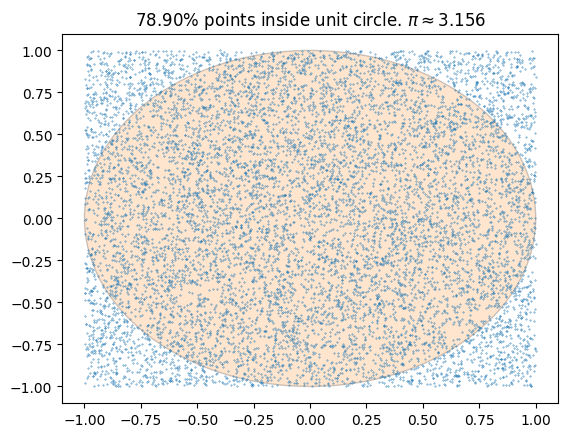

In [3]:
# Compute π by choosing random points in the square [-1, 1]^2, and checking how many lie inside the unit circle
P = rng.uniform( low=-1, high=1, size=(2,N) )

plt.gca().add_artist( plt.Circle( (0, 0), 1, color='C1', alpha=.2, ec='k' ) )
plt.scatter( P[0], P[1], s=.1 )

n_inside = np.sum( norm(P, axis=0 ) < 1 )
_ = plt.title( f'{n_inside/N*100 :.2f}% points inside unit circle. $π \\approx {4*n_inside/N}$' )

In [4]:
%%time
P = rng.uniform( low=-1, high=1, size=(N, 2) )
NN = np.arange( 1, N+1, dtype=int )
π_approx = 4 * np.cumsum( norm(P,axis=1) < 1 ) / NN

CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 6.95 ms


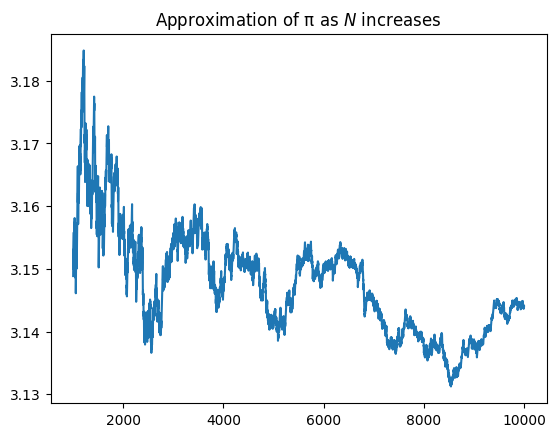

In [5]:
N0 = int(N//10)
plt.plot( NN[N0:], π_approx[N0:] )
_ = plt.title( 'Approximation of π as $N$ increases' )

Above we chose all $N$ points at the same time in the line

    P = rng.uniform( low=-1, high=1, size=(N, 2) )

Python does that much faster than if you ran your own for loop, chosing two points at a time. Let's do it 2 points at a time and see how long it takes.

In [6]:
%%time
N = 10**6
# Memory friendly, but slow (in Python) way of computing
n_inside = 0
prog = tqdm( range( N ), bar_format="{l_bar}{bar} {elapsed}<{remaining}, {rate_fmt}{postfix}" )
for n in prog:
    P = rng.uniform( -1, 1, size=2 )
    n_inside += ( norm(P) < 1 )
    prog.set_description_str( f'π≈{4*n_inside/(n+1):.6f}, error≈{abs( 4*n_inside/(n+1) - pi):.3e}', refresh=False )

  0%|           00:00<?, ?it/s

CPU times: user 17.3 s, sys: 381 ms, total: 17.7 s
Wall time: 26.7 s


On my computer it was a lot faster to choose all points at one shot, as opposed to chosing them one by one. The downside of chosing all points in one shots is that it consumes a lot of memory. It's relatively common to choose $N \approx 10^9$ for instance; If you do that in one shot, it will cost you about 8GB memory. If that's close to how much memory you have available, it's going to slow down your computer a lot.

One compromize is to do the MC simulation in chunks. That is, pick `chunk_size` small, and drop `chunk_size` points randomly, and iterate.

In [7]:
%%time
# Faster, memory friendly way of computing
# Can get even faster by parallelizing, but don't get carried away... now

chunk_size = int(N//100)
n_chunks = N // chunk_size # Choose N to be a multiple of chunk_size

n_inside = 0
prog = tqdm( range( n_chunks ), bar_format="{l_bar}{bar} {elapsed}<{remaining}, {rate_fmt}{postfix}" )
for n in prog:
    P = rng.uniform( -1, 1, size=(2, chunk_size) )
    n_inside += np.sum( norm(P, axis=0) < 1 )

    π_approx = n_inside / (n+1) / chunk_size * 4
    prog.set_description_str( f'π={π_approx:.6f}, error≈{abs(π_approx - pi):.3e}', refresh=False )

print( f'Memory used ≈ {P.nbytes / 2**20}mb' )

  0%|           00:00<?, ?it/s

Memory used ≈ 0.152587890625mb
CPU times: user 51.6 ms, sys: 24 µs, total: 51.6 ms
Wall time: 59.9 ms


### Visualizing the error as N gets large

Perform `n_trials` MC simulations for a large `N`, and visualize the error as `N` gets large.

In [8]:
n_trials = 10**3
N = 10**6
chunk_size = 10**4
NN = np.arange( chunk_size, N, chunk_size )

print( f'Roughly {len(NN) * n_trials * 8 / 2**20:.3f}mb memory required.' )

Roughly 0.755mb memory required.


In [9]:
π_approx = np.empty( (len(NN), n_trials) )

for i, n in tqdm( enumerate(NN), total=len(NN) ):
    P = rng.uniform( -1, 1, size=(2, chunk_size, n_trials) )
    n_inside = np.sum( norm(P, axis=0) < 1, axis=0 )
    if i == 0: π_approx[i] = n_inside / n * 4
    else: π_approx[i] = (NN[i-1]* π_approx[i-1] + n_inside *4 ) / n

π_avg = np.mean( π_approx, axis=-1 )
σ = np.std( π_approx, axis=-1 )

  0%|          | 0/99 [00:00<?, ?it/s]

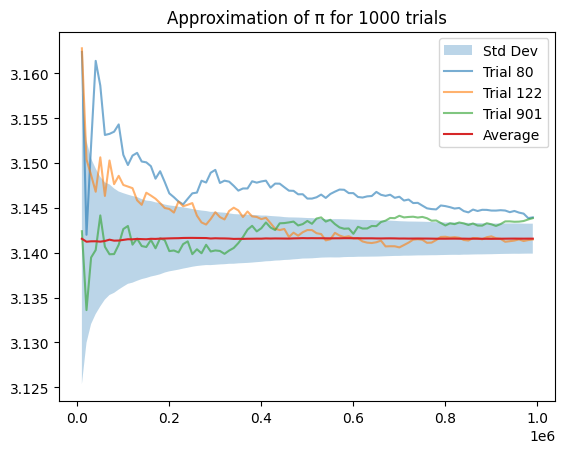

In [10]:
plt.fill_between( NN, π_avg - σ, π_avg + σ, alpha=.3, label='Std Dev' )
for n in sorted( rng.choice( n_trials, replace=False, size=3) ):
    plt.plot( NN, π_approx[:, n], alpha=.6, label=f'Trial {n+1}' )

plt.plot( NN, π_avg, label='Average' )
_ = plt.title( f'Approximation of π for {n_trials} trials' )
plt.legend()

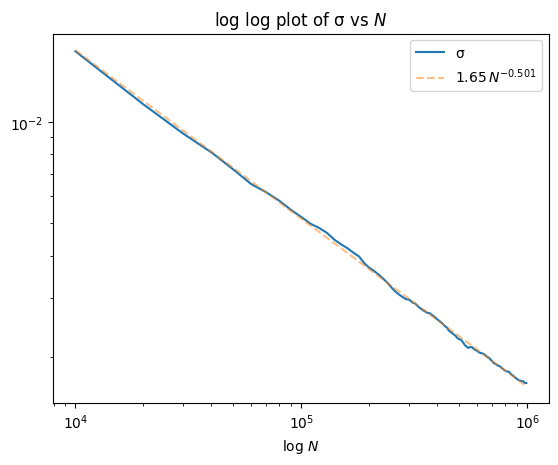

In [11]:
plt.loglog( NN, σ, label='σ' )

a = np.polyfit( log(NN), log(σ), 1 )
plt.loglog( NN, exp( a[0]*log(NN) + a[1] ), '--', alpha=.5, label=f'${exp(a[1]):.2f}\\, N^{{ {a[0]:.3f} }}$' )

_= plt.xlabel( 'log $N$' )
_ = plt.title( f'log log plot of σ vs $N$' )
plt.legend()

## Volume of a $d$-dimensional ball

Let's now compute the volume of a $d$ dimensional ball in two ways.

1. By quadrature: Divide up the $d$ dimensional cube into (roughly) $N$ cubes of equal sidelength, and count the number that are inside the unit ball.

2. By Monte Carlo simulation: Randomly choose $N$ points and count how many lie inside the unit ball:

$$
    \text{vol}(B(0, 1)) = \int_{B(0,1)} \mathbf{1}_{B(0, 1)}(x) \, dx
    = \lim_{N \to \infty} \frac{1}{N} \sum_{n = 1}^N \mathbf{1}_{B(0,1)}(X_n)
$$

In [12]:
# Compute by quadrature.
N = 10**7 #Warning -- start with N small, and ensure you have enough memory.
d = 10

V_1d = np.linspace( -1, 1, num=int( ceil(N**(1/d)) ) )
dx = V_1d[1] - V_1d[0]
V_1d = dx/2 + V_1d[:-1] # Centers of squares in one axis

V = [ V_1d for _ in range(d) ]
xx = np.meshgrid( *V ) # Centers of squares in d dim

n_inside = np.sum( norm(xx, axis=0) < 1 )
vol = n_inside * dx**d

# Closed form volume from Wikipedia: https://en.wikipedia.org/wiki/Volume_of_an_n-ball
exact_vol = pi**(d/2) / sp.special.gamma( d/2 + 1 )
print( f'd={d}, Computed vol={vol:.3f}, exact vol={exact_vol:.3f}, error={abs(vol - exact_vol):.2e}' )
print( f'Memory used ≈ {d*xx[0].nbytes / 2**20}mb' )

del xx

d=10, Computed vol=3.071, exact vol=2.550, error=5.21e-01
Memory used ≈ 745.0580596923828mb


In [13]:
# Compute by Monte Carlo
d = 10
N = 10**7

exact_vol = pi**(d/2) / sp.special.gamma( d/2 + 1 )

chunk_size = 10**5
n_chunks = N // chunk_size # Choose N to be a multiple of chunk_size

n_inside = 0
prog = tqdm( range( n_chunks ), bar_format="{l_bar}{bar} {elapsed}<{remaining}, {rate_fmt}{postfix}" )
for n in prog:
    P = rng.uniform( -1, 1, size=(d, chunk_size) )
    n_inside += np.sum( norm(P, axis=0) < 1 )

    vol = n_inside / (n+1) / chunk_size * 2**d
    prog.set_description_str( f'vol={vol:.6f}, error≈{abs(vol-exact_vol):.3e}', refresh=False )

print( f'd={d}, Computed vol={vol:.6f}, exact vol={exact_vol:.6f}, error={abs(vol - exact_vol):.2e}' )
print( f'Memory used ≈ {P.nbytes / 2**20}mb' )

  0%|           00:00<?, ?it/s

d=10, Computed vol=2.545766, exact vol=2.550164, error=4.40e-03
Memory used ≈ 7.62939453125mb


## Few take aways

1. Quadrature works better in low dimensions (1 and 2).
2. Quadrature becomes worse in higher dimensions. Error is like $1/N^{1/d}$.
3. Monte-Carlo works better in higher dimensions: Error is like $1/\sqrt{N}$.

Practically the above Monte Carlo method works till about dimension 10/15, depending on how large you can make $N$. Beyond that, the ratio of the volume of the unit ball to the volume of the bounding box decreases exponentially with $d$. So in order to obtain a reasonable estimate, you have to increase $N$ a lot to compensate.
This is known as the *curse of dimensionality*, and you can read about it on [Wikipedia](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

Note, in high dimensions most of your sample points are outside the unit ball. You can get better results by tuning your sample distribution.